# Test the TextureDreambooth LoRAs and visualize the example output

In [1]:
import os
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline
from peft import PeftModel, LoraConfig
import numpy as np

In [2]:
# create log directory by date
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')
log_dir = f"logs/{today}"
os.makedirs(log_dir, exist_ok=True)

Create a SD pipeline for image generation. It will combine the weights of the base model with the fine-tuned LoRA weights using LoraConfig

In [ ]:
def get_lora_sd_pipeline(
    ckpt_dir, base_model_name_or_path=None, dtype=torch.float16, device="cuda", adapter_name="default"
):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if os.path.exists(text_encoder_sub_dir) and base_model_name_or_path is None:
        config = LoraConfig.from_pretrained(text_encoder_sub_dir)
        base_model_name_or_path = config.base_model_name_or_path

    if base_model_name_or_path is None:
        raise ValueError("Please specify the base model name or path")

    pipe = StableDiffusionPipeline.from_pretrained(base_model_name_or_path, torch_dtype=dtype).to(device)
    pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)

    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder = PeftModel.from_pretrained(
            pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
        )

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe

Create a SD pipeline using the LoRA weights we have created during the fine-tuning step.

In [4]:
def check_lora_example_output(class_prefix, negative_prompt = "", guidance_scale = 7, postfix = ""):

    finetune_output_dir = f"output/lora_{class_prefix}_sks"
    base_model_name = "CompVis/stable-diffusion-v1-4"
    pipe = get_lora_sd_pipeline(finetune_output_dir, base_model_name_or_path=base_model_name, adapter_name=f"{class_prefix}_texture")

    prompt = f"sks normal map"

    DESTINATION_PATH_FOR_THE_IMAGE=f"{finetune_output_dir}/inference_output_guidance_{guidance_scale}{postfix}.jpg"
    image = pipe(prompt, num_inference_steps=50, guidance_scale=guidance_scale, negative_prompt=negative_prompt).images[0]
    image.save(DESTINATION_PATH_FOR_THE_IMAGE) # (512, 512)

    plt.imshow(image)
    plt.show()

Use base_model_name_or_path CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

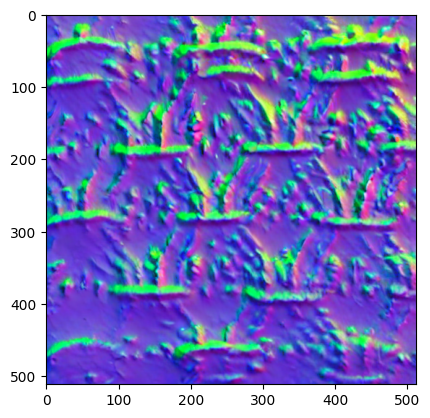

Use base_model_name_or_path CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

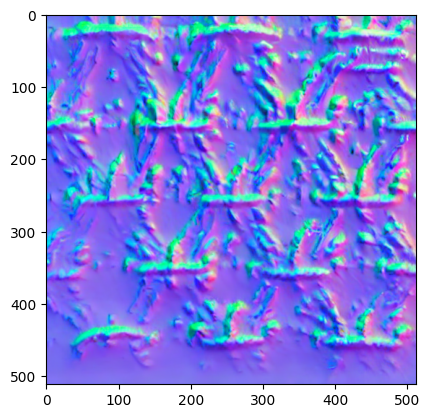

Use base_model_name_or_path CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

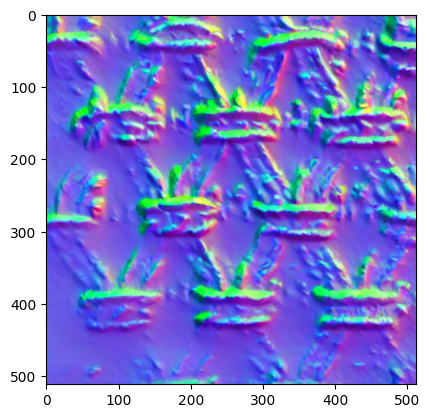

Use base_model_name_or_path CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

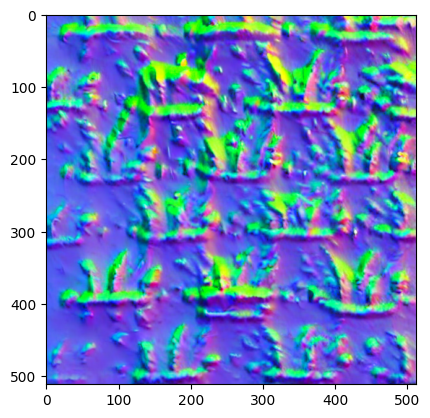

Use base_model_name_or_path CompVis/stable-diffusion-v1-4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

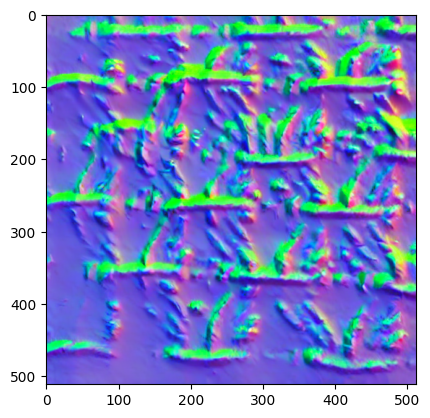

In [6]:
class_prefix_list = ['redcloth1'] # , 'avocado', 'glasstumbler', 'football', 'corn', 'goldgoat', 'metalframe', 'strawhat', 'cuttingboard', 'spongehard', 'strawberry', 'orangeglove', 'strawberryleaves', 'greensweater', 'footballhandle', 'potato', 'orange', 'trunk', 'clothbag', 'cantaloupe', 'tabletennishandle', 'redcloth2', 'spongesoft', 'blackbase', 'tabletennisface', 'rock', 'corkmat', 'whitesponge', 'pinkcloth', 'purpleglove'

for class_prefix in class_prefix_list:
    # generate multiple images to check the diversity
    for _ in range(5):
        check_lora_example_output(class_prefix, negative_prompt = "", guidance_scale = 10, postfix = f"_{_}")
